# setup

In [1]:
import gc
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
from functools import lru_cache, partial
from typing import Iterable, Optional

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import torch
from accelerate import Accelerator
from evaluate import load
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import as_stacked_batches
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.itertools import Cached, Cyclic
from gluonts.time_feature import (
    TimeFeature, get_lags_for_frequency,
    get_seasonality,
    time_features_from_frequency_str
)
from gluonts.transform import (
        AddAgeFeature, AddObservedValuesIndicator,
        AddTimeFeatures, AsNumpyArray, Chain,
        ExpectedNumInstanceSampler, InstanceSplitter,
        RemoveFields, RenameFields, SelectFields,
        SetField, TestSplitSampler, Transformation,
        ValidationSplitSampler, VstackFeatures
)
from gluonts.transform.sampler import InstanceSampler
from IPython.display import display
from pandas.core.arrays.period import period_array
from torch import nn
from torch.optim import AdamW
from transformers import (
    InformerConfig, InformerForPrediction,
    PretrainedConfig
)
from transformers.utils import send_example_telemetry


In [2]:
plt.style.use('fivethirtyeight')

# data

In [3]:
df = pd.read_parquet("../data/01_raw/btc_raw_history_1d.parquet")
df["formatted_date"] = pd.to_datetime(df["formatted_date"])
df = df.sort_values(by="formatted_date")
df 

,date,high,low,open,close,volume,adjclose,formatted_date
0,1410912000,468.174011,452.421997,465.864014,457.334015,21056800,457.334015,2014-09-17
1,1410998400,456.859985,413.104004,456.859985,424.440002,34483200,424.440002,2014-09-18
2,1411084800,427.834991,384.532013,424.102997,394.795990,37919700,394.795990,2014-09-19
3,1411171200,423.295990,389.882996,394.673004,408.903992,36863600,408.903992,2014-09-20
4,1411257600,412.425995,393.181000,408.084991,398.821014,26580100,398.821014,2014-09-21
...,...,...,...,...,...,...,...,...
3413,1705795200,41855.367188,41497.007812,41671.488281,41545.785156,9344043642,41545.785156,2024-01-21
3414,1705881600,41651.207031,39450.117188,41553.652344,39507.367188,31338708143,39507.367188,2024-01-22
3415,1705968000,40127.351562,38521.894531,39518.714844,39845.550781,29244553045,39845.550781,2024-01-23
3416,1706054400,40483.785156,39508.796875,39877.593750,40077.074219,22359526178,40077.074219,2024-01-24


In [4]:
THRESHOLD_INDEX = 365
train_dataset = df[["formatted_date", "close"]].set_index("formatted_date").iloc[:-THRESHOLD_INDEX].copy()
test_dataset = df[["formatted_date", "close"]].set_index("formatted_date").iloc[-THRESHOLD_INDEX:].copy()

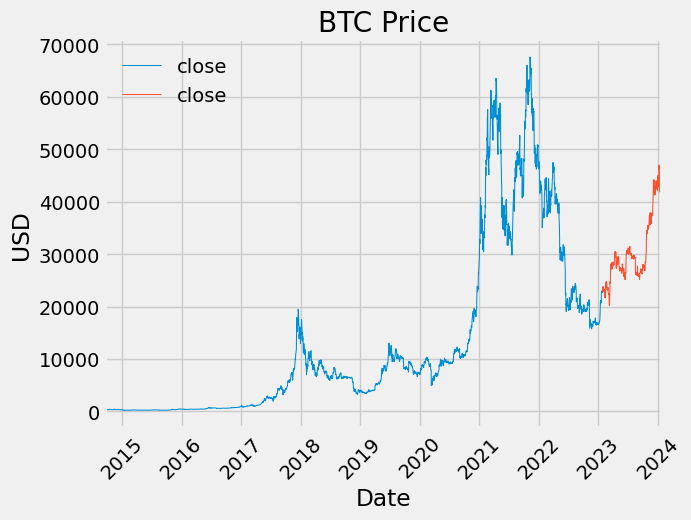

In [5]:
_, axs = plt.subplots(1, 1,)

train_dataset.plot(ax=axs, label="train", linewidth=0.75)
test_dataset.plot(ax=axs, label="test", linewidth=0.75)
axs.legend(frameon=False,)

axs.set_title("BTC Price")
axs.set_ylabel("USD")
axs.set_xlabel("Date")

for tick in axs.get_xticklabels():
    tick.set_rotation(45)

plt.show()

# training

.